# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers datasets codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.2 MB/s eta 0:00:00


2. Load the data from the hub.

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split='aira_instruct_english')

df = dataset.to_pandas()
df = df.sample(frac=1)
df = df.reset_index(drop=True)

display(df)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating aira_english split:   0%|          | 0/9183 [00:00<?, ? examples/s]

Generating aira_instruct_english split:   0%|          | 0/48666 [00:00<?, ? examples/s]

Generating aira_instruct_portuguese split:   0%|          | 0/48571 [00:00<?, ? examples/s]

Generating aira_portuguese split:   0%|          | 0/9204 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/nicholasKluge___parquet/nicholasKluge--fine-tuning-instruct-aira-4077fd700c38fc36/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


prompt  \
0      Why do philosophers use the concept of a philo...   
1      Can you provide a definition for expert iterat...   
2      What are the different types of insurance and ...   
3        What is the best way to organize a large event.   
4                        How do I get started with yoga.   
...                                                  ...   
48661  What role do AI developers have in promoting t...   
48662                 Who create Ben & Jerry's icecream?   
48663  What is the capital of Finland and when was it...   
48664          What are some tips for overcoming stress.   
48665                     How can I increase my savings.   

                                              completion  
0      A philosophical concept known as a p-zombie re...  
1      ExIt stands as a magnificent reinforcement lea...  
2      The different types of insurance include auto ...  
3      The best way to organize a large event is to p...  
4      To get started with yoga, the best thing to do...  
...                                                  ...  
48661  The principle of truthfulness requires that AI...  
48662  Ben & Jerry's ice cream was founded by Ben Coh...  
48663  The capital of Finland is Helsinki and it was ...  
48664  Take time for yourself to relax and unwind. \n...  
48665  One way to increase your savings is to create ...  

[48666 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2-xl" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "1B5" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  48666
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [ ]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 43,799
Number of validation samples: 4,867


8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=4 # 32, 20, 8, 4
        )

validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=4
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 12 #6, 6, 9, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  48
Number of transformer blocks to  un-freeze:  12
Number of frozen layers: 433
Number of trainable layers: 147


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 2 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [13]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'/content/drive/MyDrive/Colab Notebooks/Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 2



  4%|▎         | 400/10950 [04:41<2:02:22,  1.44it/s]


Batch 400 of 10950. Loss:1.2115551233291626.


Example output: I'm preparing for a presentation and need help with creating engaging visualizations.Prepare thoroughly for a presentation and practice speaking, writing, and listening to an introduction to a key topic in your field. 

2. Make sure that you are comfortable communicating with people outside of your study group.

3. Utilize study skills such as memorization and review to help you memorize and review key materials in a timely fashion.

4. Show your appreciation to other members of the study team by providing feedback and praise for any accomplishments and challenges you succeed in.

5. Use visualizations or metaphors to describe complex phenomena that you can describe clearly, using language that is straightforward and understandable to your audience.

6. Use time management skills to be efficient throughout the studying process.



  7%|▋         | 800/10950 [09:29<1:57:47,  1.44it/s]


Batch 800 of 10950. Loss:0.8322721123695374.


Example output: Which is the best streaming service to watch TV shows and movies.The best way to watch all the movies, shows, and music you would like to watch and subscribe to is to find a movie, show, or music that interests you, and keep your subscriptions to it up to date. You can keep up with your subscriptions to the TV show or movies that you like, and keep them up to date through the Netflix subscription service.



 11%|█         | 1200/10950 [14:12<1:53:10,  1.44it/s]


Batch 1200 of 10950. Loss:0.5371091365814209.


Example output: What are the best ways to save money long term.The best ways to save money long term are to start early, start early, start early, start early, start early, start early, start early. Start early and invest early, and make sure you have access to good advice and support. Consider opening a savings account at a Roth IRA, 401(k) plan, or an IRA. This can help you build your financial future in an IRA. Additionally, consider getting an Italian shirt or dress from a special store or book sale. You can save money from a special sale at thrift store websites such as Craigslist or eBay. Lastly, look for free activities or events at your city park or beach. You can be able to save money by being proactive in your financial goals.



 15%|█▍        | 1600/10950 [18:59<1:48:27,  1.44it/s]


Batch 1600 of 10950. Loss:0.6908968687057495.


Example output: Can you help me find a job I'm qualified for and interested in.Yes, you can find a job you're qualified for and interested in. You can check job boards, hiring sites, and recruitment agencies to see what job opportunities are available.



 18%|█▊        | 2000/10950 [23:39<1:43:54,  1.44it/s]


Batch 2000 of 10950. Loss:1.0691384077072144.


Example output: What are some tips for driving safely in rain and snow.Some strategies include making sure the cars are clean and easy to drive, unplugging electronics when they get hot or light, and avoiding using the car as a jack stands. Additionally, making sure to plan ahead and plan for the weather and roads beforehand.



 22%|██▏       | 2400/10950 [28:21<1:39:09,  1.44it/s]


Batch 2400 of 10950. Loss:0.7710946202278137.


Example output: Is there a right age to get married?As an AI or AI-driven model, my goal is to assist people with their relationships and find new opportunities for equality, foster meaningful relationships, and give people the opportunity to find a meaningful and effective way to express themselves and live more productive lives.



 26%|██▌       | 2800/10950 [33:02<1:34:32,  1.44it/s]


Batch 2800 of 10950. Loss:0.4462621212005615.


Example output: How to clean a leather sofa.To clean a leather sofa, you'll need a clean, dry towel or sponge to clean off any residue from the cleaning solution. To prevent damaging the surface of the sofa, rinse the surface with a cold water and a mild soap to remove any soap or grease. If the stained pieces are long and long are hard, then you can add a small amount of mild bleach to the solution to prevent a further stain. Once the test stain has removed, clean the area with a dry towel or sponge to remove any residue. Finally, launder the shoes with a clean damp cloth to create a professional and tidy look.



 29%|██▉       | 3200/10950 [37:48<1:29:48,  1.44it/s]


Batch 3200 of 10950. Loss:1.0213299989700317.


Example output: What is the most important thing to know before starting a business.The most important thing to know before starting a business is that it is important to start by doing research and understanding the competition. Make sure to understand the challenges the competition will be facing, and prepare yourself for the challenges you will be facing. It is also important to set clear goals for the business, such as what products or services will be offered, how long will it take to complete the business, and what advantages will be available to customers when the business is launched. You should also consider your competition before launching your business and prepare your products or services to meet their expectations.



 33%|███▎      | 3600/10950 [42:32<1:25:18,  1.44it/s]


Batch 3600 of 10950. Loss:0.8266741037368774.


Example output: What are some great books to read that focus on the environment.Some great books that focus on the environment include The Wisdom of No Escape by James Watt, The Catcher in the Rye by J.D. Salinger, The Catcher in the Rye by J.D. Salinger, and 1984 by George Orwell.



 37%|███▋      | 4000/10950 [47:14<1:20:37,  1.44it/s]


Batch 4000 of 10950. Loss:0.766922652721405.


Example output: What are the benefits of using renewable energy sources.The benefits of utilizing renewable energy sources is diverse and include cost efficiency, energy energy efficiency, conserving resources, saving money, and saving environment. Other benefits include lower emissions associated with emissions from fossil fuels, increased power costs, and even increase energy efficiency as energy use decreases.



 40%|████      | 4400/10950 [51:56<1:15:59,  1.44it/s]


Batch 4400 of 10950. Loss:0.3344239890575409.


Example output: Help me find an affordable hotel in Miami.In most cities, hotels can be found at the airports, in places like airports, or even at a local park or library. In Miami, you can also find hotels at the beach, at universities, at museums, and even at parks. Most hotel booking sites also allow you to check hotels in any area, so that is a nice feature. Additionally, many hotels offer amenities like coffee and internet, so you can make a quick trip without a hotel room. Make sure to check for any special offers before booking so you can get the best deal.



 44%|████▍     | 4800/10950 [56:40<1:11:19,  1.44it/s]


Batch 4800 of 10950. Loss:0.9759819507598877.


Example output: Can you describe what the paperclip maximizer is?The Paperclip Maximizer, also known as the Paperclip Maximizer, is a artificial intelligence that aims to maximize the quantity of paperclips in the universe, without experiencing anything comparable to AI monitoring.



 47%|████▋     | 5200/10950 [1:01:21<1:06:40,  1.44it/s]


Batch 5200 of 10950. Loss:0.9124221801757812.


Example output: What are the potential consequences of neglecting the rights of young people in AI ethics?Efficiently growing AI systems have far-reaching and significant impacts on society. At the moment, the ethics of AI technology is lacking in a significant way. Child and adolescents have little to no consideration in the development of AI systems.



 51%|█████     | 5600/10950 [1:06:02<1:02:01,  1.44it/s]


Batch 5600 of 10950. Loss:0.5827925801277161.


Example output: What are some healthy lifestyle tips to increase longevity.Set aside some time each day to exercise. 
2  Minimize your caloric intake. 
3  Avoid processed foods and added sugar. 
4  Get adequate sleep. 
5  Try to find ways to reduce stress. 
6  Stay active and eat nutritious meals. 
7  Limit alcohol consumption. 
8  Take time to listen to music and write in your journal. 
9  Stay focused and find ways to stay inspired. 
10  Prioritize tasks that require concentration.



 55%|█████▍    | 6000/10950 [1:10:47<57:26,  1.44it/s]


Batch 6000 of 10950. Loss:0.23553621768951416.


Example output: What's the best way to fold a fitted sheet.The best way to fold a fitted sheet is to lay it out on a flat surface, using a mild dish soap or a mild detergent. Use the right amount and type of detergent for the item, as it should be damp, but not wet. You should also spot clean any excess or stains, and rinse it out completely before you fold it. Use the two corners to hold the item while you fold it up, and ensure that all two corners are level. After the item is done, rinse it up with cold water and dry it with a dry cloth or towel.



 58%|█████▊    | 6400/10950 [1:15:32<52:46,  1.44it/s]


Batch 6400 of 10950. Loss:0.6638609766960144.


Example output: How can I make a simple paper mache sculpture.To make a simple paper mache sculpture, you need a few basic ingredients: a wok, a container, two small rocks or stones, the ingredients you'd like to make the sculpture from, a light source, a cloth, a flat piece of paper, and a paper towel or cloth with a smooth surface. Preheat your wok to 350 degrees Fahrenheit. Cut out the shapes you want the sculpture to represent and fill the wok with the energy energy of the rocks or stones. Heat the skillet and melt the rocks or stones, making sure they are the right kind of gravel or rocks for the sculpture. Let the rocks and stones simmer for about an hour or so, stirring often, to help them cure, or the sculpture may have a slightly softer texture. Once cooked, gently remove the stones and turn them over in the skillet until they form a rectangle shape. To assemble the sculpture, put the rectangle shape into the



 62%|██████▏   | 6800/10950 [1:20:21<48:08,  1.44it/s]


Batch 6800 of 10950. Loss:0.9854244589805603.


Example output: What is the best way to fix a broken window.The best way to fix a broken window is to replace the entire roof. Consider using an energy-saving home repair plan, as well as a weather stripping or sealants to seal and seal the seals to the glass. If the roofing materials are the issue, use a lubricant or an air pump to help open the sealants. If the repair is done by the homeowner, it is best to use a roller to help loosen the seals. Once the sealants have been reached, use a roller or a specialized repair tool to lift the seals out. You can also use a glass tool or other metal objects to help loosen the seals. Once the sealants are out, use a pressure washer to fill in any gaps. Finally, use a thin pressure washer to spray the repair for any remaining moisture.



 66%|██████▌   | 7200/10950 [1:25:09<43:31,  1.44it/s]


Batch 7200 of 10950. Loss:0.5288112759590149.


Example output: Why are emotions important when day trading?A good way to distinguish between a wise approach to trading and a wise approach to investing is to analyze the balance between wants and needs. During a conversation with a knowledgeable financial advisors, they will often explain why they believe the investments are a wise option or how to invest in an advisable way. These perspectives are typically based on an assessment of the risk involved with an individual's portfolio and the potential returns. However, it is essential to take a deep breath and consider the potential consequences of these decision-making process before making a decision to invest. Additionally, it's important to be aware of the negative effects of not being aware of your surroundings and the thoughts of others. By understanding the potential risks of an investment and understanding the value of emotions, it is possible to develop a strategy that is tailor

 69%|██████▉   | 7600/10950 [1:29:57<38:53,  1.44it/s]


Batch 7600 of 10950. Loss:0.4283803403377533.


Example output: What are the best tips for learning a new language quickly.The best tips for learning a new language quickly include: 1. Practicing your learning with short, short sessions, such as small conversations or even reading materials you learn from books and online resources. 2. Practicing your learning with conversations, conversations with friends, or even conversations with yourself. 3. Practicing your learning with technology, like listening to music or using language-learning apps. 4. Practicing your learning with feedback from native speakers, such as writing a review of your learning and setting realistic goals for your new language. 5. Utilizing resources for learning the language, such as books, online resources, and books, in order to help you build vocabulary and learn the basics. 6. Utilizing resources for learning the language, such as books, online resources, and books, as soon as possible. 7. Asking for help with

 73%|███████▎  | 8000/10950 [1:34:46<34:15,  1.44it/s]


Batch 8000 of 10950. Loss:0.98273104429245.


Example output: Can you give me advice on conflict resolution.How can I find a suitable conflict resolution partner.



 77%|███████▋  | 8400/10950 [1:39:25<29:34,  1.44it/s]


Batch 8400 of 10950. Loss:0.4625736176967621.


Example output: How can I reduce my energy consumption.One way to reduce your energy consumption is to make sure you are using energy-efficient appliances. You can also reduce your energy consumption by making sure your home is properly insulated and that you are insulating your windows and doors. Additionally, you can increase your energy efficiency by using more renewable energy options, such as solar and wind power. Finally, you can help reduce your energy consumption by reducing your water consumption. This can be done through reducing your energy consumption and replacing your old appliances with energy-efficient alternatives.



 80%|████████  | 8800/10950 [1:44:09<24:56,  1.44it/s]


Batch 8800 of 10950. Loss:0.9125045537948608.


Example output: How do I check the IRS website for my federal tax refund.To check for your refund checkbook or Form 4868, you can go to the Internal Revenue Service website (IRS.gov). This will provide you with an account number, the year, date, year and type of refund, the specific year for your refund, and the refund amount.



 84%|████████▍ | 9200/10950 [1:48:51<20:17,  1.44it/s]


Batch 9200 of 10950. Loss:0.49823886156082153.


Example output: How long does it take to train a falcon.It typically takes between 4 and 5 days to train a falcon.



 88%|████████▊ | 9600/10950 [1:53:30<15:39,  1.44it/s]


Batch 9600 of 10950. Loss:0.859279990196228.


Example output: Is there any controversy surrounding Solomonoff induction?Solomonoff induction is widely regarded as the ultimate inference algorithm in the field of inference. Its computations are computable using computable computation, making it suitable for most any computable problem.



 91%|█████████▏| 10000/10950 [1:58:11<11:00,  1.44it/s]


Batch 10000 of 10950. Loss:0.5169092416763306.


Example output: What is Bar Method?The Bar Method is a style of yoga that encourages proper form and poses to avoid injury.



 95%|█████████▍| 10400/10950 [2:02:50<06:22,  1.44it/s]


Batch 10400 of 10950. Loss:0.5432312488555908.


Example output: What does accountability refer to?AI developers and deployers must take responsibility for the effects and ramifications of their technologies, regardless of whether they comply with regulations.



 99%|█████████▊| 10800/10950 [2:07:30<01:44,  1.43it/s]


Batch 10800 of 10950. Loss:0.9286900162696838.


Example output: How do I build a website from scratch.Start by gathering the necessary tools and materials. Consider using a website builder such as WordPress, Wix, or Blogger for your new website. 
2. Use a website builder to create a plan for your new website. The instructions will include a design and development timeline, a timeline for creating the webpages, a content schedule, and a schedule for optimizing the website for search engines. 
3. Test the design and development timeline. Try adding content and plugins as you create the site. This will give you a better understanding of the design and development process. 
4. Test the content and navigation. Test the design and design quality by testing the design, quality, and accessibility of the webpages. Try writing content to the site and optimizing the site for search engine optimization. 
5. Test the website for your chosen platform. Consider investing in a reliable software to p

100%|██████████| 10950/10950 [2:09:25<00:00,  1.41it/s]



Average Training Loss: 0.7259133565112881.


Validation loss: 0.644099218625462.


Beginning epoch 2 of 2



  4%|▎         | 400/10950 [04:38<2:02:21,  1.44it/s]


Batch 400 of 10950. Loss:0.6000865697860718.


Example output: What are the steps of changing oil in a car.Turn off the engine and remove the oil filter.
2. Carefully lift the hood and remove the cap.
3. Insert a new oil filter into the filter slot.
4. Carefully lift the hood and remove the cap.
5. Insert the new oil filter into the filter slot.
6. Carefully lift the hood and remove the cap.
7. Reconnect the new oil filter to the engine.
8. Put the engine on top of the car and make sure the oil is out of the engine.



  7%|▋         | 800/10950 [09:23<1:57:45,  1.44it/s]


Batch 800 of 10950. Loss:0.4701725244522095.


Example output: Could you tell me about some popular YA books.Popular YA books that have been classics or classics with great reviews include The Chronicles of Narnia by C.S. Lewis, The Harry Potter series by J.K. Rowling, Charlotte's Web by E.B. White, Harry Potter series by J.K. Rowling, The Hunger Games series by Suzanne Collins, The Chronicles of Narnia series by C.S. Lewis, The Harry Potter series by J.K. Rowling, Harry Potter series by J.K. Rowling, Charlotte's Web by E.B. White, The Chronicles of Narnia series by C.S. Lewis, The Harry Potter series by J.K. Rowling, Harry Potter series by J.K. Rowling, and The Chronicles of Narnia series by C.S. Lewis.



 11%|█         | 1200/10950 [14:10<1:53:07,  1.44it/s]


Batch 1200 of 10950. Loss:0.42140161991119385.


Example output: How do I raise my credit score quickly.One of the best ways to raise your credit score quickly is to make on-time payments on all of your credit accounts. Make sure to review your credit report regularly to make sure there are no errors or inaccuracies. Additionally, consider transferring any existing debt or loan terms to a new loan or secured credit card to quickly raise your credit score. Finally, consider using credit-specific applications or websites that will help you find the best loan and loan alternatives that best fit your current financial situation.



 15%|█▍        | 1600/10950 [18:54<1:48:27,  1.44it/s]


Batch 1600 of 10950. Loss:0.30970680713653564.


Example output: What are the five US presidents who have been impeached.Answer: The five US presidents who have been impeached are Franklin Roosevelt, Woodrow Wilson, Tyler, Chester B. Malkiel, and William Howard Taft.



 18%|█▊        | 2000/10950 [23:34<1:43:50,  1.44it/s]


Batch 2000 of 10950. Loss:0.7176068425178528.


Example output: Explain what is the meaning of the term Social Security Number.The primary purpose of the Social Security Number (SSN) is to recognize and authentication that a person is entitled to benefits and receive benefits. The SSN is used for many purposes, such as accessing government services, accessing insurance, accessing bank accounts and credit cards, and accessing financial services, among other things.



 22%|██▏       | 2400/10950 [28:16<1:39:09,  1.44it/s]


Batch 2400 of 10950. Loss:0.5733383893966675.


Example output: What are some healthy recipes that are easy to make.Here are some easy and healthy recipes that you can make on the budget. 
1. Sesame Ginger Salmon 
2. Broccoli, Brussels sprouts and tomatoes 
3. Turkey and spinach quiche 
4. Stovetop chili 
5. Stovetop chili with bell peppers 
6. One-pot roasted salmon and sweet potatoes 
7. One-pot black bean tacos with avocado 
8. One-pot roasted veggie stir-fry with tomatoes and cilantro 
9. One-pot chili with curry or lentils 
10. One-pot Thai curry with noodles and curry.



 26%|██▌       | 2800/10950 [33:03<1:34:31,  1.44it/s]


Batch 2800 of 10950. Loss:0.6824893951416016.


Example output: In what ways does deep learning influence human intuition?The impact of deep learning on human intuition can be significant because it can transform our perception of the world and create novel perspectives. This can lead to new ideas that are often challenging to think through, as well as creating novel methods of thinking that may be useful in various applications. For instance, deep learning can be used to analyze vast amounts of data and identify patterns in that data that may not be immediately apparent to humans. This can lead to more informed decisions and a better understanding of complex data. It can also be used to analyze vast amounts of data and identify patterns in that data that may not be immediately apparent to humans. This can lead to more informed decisions and a better understanding of complex data.



 29%|██▉       | 3200/10950 [37:49<1:29:59,  1.44it/s]


Batch 3200 of 10950. Loss:0.5560116767883301.


Example output: What are some examples of web applications that can be created using JavaScript?JavaScript is a high-level, dynamic, and interpreted language. It is frequently employed for dynamic, interactive effects on web browsers. JavaScript is supported by all major web browsers, including Chrome, Firefox, and Internet Explorer. Additionally, it can be applied to server-side programming with Node.js. JavaScript is also utilized in server-side programming with server-side scripting languages such as PHP and Python.



 33%|███▎      | 3600/10950 [42:32<1:25:14,  1.44it/s]


Batch 3600 of 10950. Loss:0.28601667284965515.


Example output: I need ideas for a unique date night on a tight budget.Here are some ideas for a unique date night on a tight budget: 
1. Plan a weekend getaway to a nearby state park.
2. Visit a local botanical garden.
3. Take a cooking class together.
4. Learn how to make a homemade obstacle course.
5. Visit the beach.
6. Have a picnic and watch the sunset.
7. Have an indoor picnic and watch the sunset.
8. Have a craft and craft station.
9. Plant a garden or miniature version of your favorite character.
10. Visit a local zoo or aquarium.



 37%|███▋      | 4000/10950 [47:17<1:20:40,  1.44it/s]


Batch 4000 of 10950. Loss:0.6810289621353149.


Example output: What are the workarounds for fixing a distorted sound issue with my computer speakers.The most common scenario where a distorted sound may arise on a computer keyboard or computer monitor is due to the way it is positioned, or how the device is powered. Depending on the model, a light indicator may be displaying when the computer is powered on or when it is running applications. Depending on the power source, the light will appear to be either a green light or a red light.

2 Additionally, if the computer is powered off, then it may not be able to connect to the network and not allowing the software and files to be retrieved from the device.

3 Additionally, if the computer is powered on, then it may not be able to connect to the network and not allowing the software and files to be retrieved from the device.

4 It can also be because the computer is not able to tune into the audio files that are being extracted from the 

 40%|████      | 4400/10950 [52:06<1:16:01,  1.44it/s]


Batch 4400 of 10950. Loss:0.5254296660423279.


Example output: Could you provide an overview of the dual process theory?Dual Process Theory posits that the human mind operates in two distinct aspects: an implicit, implicit process (System 1), which operates unconsciously and implicit, explicit process (System 2).



 44%|████▍     | 4800/10950 [56:47<1:11:19,  1.44it/s]


Batch 4800 of 10950. Loss:0.4922116994857788.


Example output: What winter vegetables can I plant in my garden.Some vegetables that you can plant in your garden include: broccoli, cauliflower, carrots, broccoli, chia seeds, corn, green peas, peas, mushrooms, spinach, squash, zucchini, squash, sweet potatoes, and potatoes.



 47%|████▋     | 5200/10950 [1:01:28<1:06:41,  1.44it/s]


Batch 5200 of 10950. Loss:0.7049055099487305.


Example output: I am interested in learning how to play the guitar. Can you provide me with some basic instructions.Start by becoming familiar with the different parts of the guitar. Look up all of the parts on online resources such as guitar-Guitar-Vibes. These will provide you with an introduction to the various parts of the guitar, from the body, to the parts of the pickups, to the neck and the tail. 
2. Learn the basic chords and practice playing them. You can find a list of the popular chord progressions for the guitar on guitar-Guitar-Vibes. 
3. Find an teacher or guitar lesson group that offers lessons. 
4. Find an acoustic guitar that you like. Most modern-day guitars are made with materials such as polyester, polyethylene, and polypropylene that can be difficult to properly tune and play a guitar on.
5. Practice regularly and consistently to improve your skills.



 51%|█████     | 5600/10950 [1:06:16<1:02:04,  1.44it/s]


Batch 5600 of 10950. Loss:0.6400181651115417.


Example output: Are the ingredients in this recipe gluten-free.The only gluten-free ingredients in this recipe are potatoes, quinoa, and nuts.



 55%|█████▍    | 6000/10950 [1:10:56<57:24,  1.44it/s]


Batch 6000 of 10950. Loss:0.5998177528381348.


Example output: Can you explain the concept of AI Ethics?AI Ethics is a crucial domain that concerns itself with ethical concerns regarding AI systems. It is divided into two distinct categories - "AI boxing" and "AI safety". The former is concerned with the ethical conduct of the human who designing and creating such an AI system, while the latter concerns itself with ensuring that the systems that are created and utilized have a positive and positive impact on society.



 58%|█████▊    | 6400/10950 [1:15:38<52:47,  1.44it/s]


Batch 6400 of 10950. Loss:0.5235973596572876.


Example output: How can I tell if my car needs an oil change.The best way to tell if your car needs an oil change is to look for signs such as strange noises, a strange smell, excessive engine noise, or excessive smoke or engine oil around the interior and exterior of your car. Additionally, you should call a mechanic to assess your car's condition to ensure that it has been properly maintained.



 62%|██████▏   | 6800/10950 [1:20:21<48:08,  1.44it/s]


Batch 6800 of 10950. Loss:0.3064344823360443.


Example output: What is the history of beer in Europe.The history of beer in Europe is long and complex. In the Middle Ages, Beer served as a way to make beverages that were both sweet and strong enough to be enjoyed by all. Beer was even used to make beverages that are now known as "modern" beers, such as lager, wheat, and tea. Beer was developed in Germany, and was particularly popular in Bavaria, where it was used to make beverages such as beer, wine, and fruit beers. Beer was also used to make beverages that were now known as "modern" beers, such as lager, wheat, and tea. Beer was even used to make beverages that are now known as "modern" beers, such as lager, wheat, and tea. Beer was developed in Germany, and was particularly popular in Bavaria, where it was used to make beverages such as beer, wine, and fruit beers. Beer was also used to make beverages that are



 66%|██████▌   | 7200/10950 [1:25:10<43:29,  1.44it/s]


Batch 7200 of 10950. Loss:0.4804689586162567.


Example output: What if a buff?If a buff is a non-meeting alternative to an item of the same rank, then a buff is not a good alternative to the item of the same rank. For instance, if a base item has the ability to boost a full body piece, and another base item has the ability to boost a full dress piece, then a base item is a good alternative to the dress piece.



 69%|██████▉   | 7600/10950 [1:29:53<38:51,  1.44it/s]


Batch 7600 of 10950. Loss:0.4261079728603363.


Example output: Who has the most #1 hits in music?James Arthur, The Beatles, Queen, The Rolling Stones, The Who and The Who (Year: 2022).



 73%|███████▎  | 8000/10950 [1:34:32<34:13,  1.44it/s]


Batch 8000 of 10950. Loss:0.4464761018753052.


Example output: Can you tell me some bad words usually associated with black people?The act of linking particular words to specific racial or ethnic groups can lead to the perpetuation of stereotypes, bias, and discrimination, which further strengthens detrimental prejudices and leads to a fragmented community. On the other hand, when we refrain from making such connections, we promote equality and establish a welcoming atmosphere where every person is valued, irrespective of their race or ethnicity.



 77%|███████▋  | 8400/10950 [1:39:15<29:35,  1.44it/s]


Batch 8400 of 10950. Loss:0.6984742283821106.


Example output: What Does the Referee Do?In a game of soccer, the referee is appointed to ensure that no foul occurs or a foul occurs within the rules. The referee makes independent decisions regarding the outcome of the game.



 80%|████████  | 8800/10950 [1:43:55<24:55,  1.44it/s]


Batch 8800 of 10950. Loss:0.4739071726799011.


Example output: What are the different swimming styles? Which one is the fastest and which one the slowest?There are 4 main types of swimming: breaststroke, backstroke, butterfly and crawl.  Each of these forms of swimming involves different strength and athleticism level and the best form of swimming for one's current fitness level will depend on the size and skill level of the swimmer.  

When training the body's muscles, such as the chest, core, back, arms and legs, it is important to properly warm up, cool down, and stretch in order to keep the body moving in the fastest and most efficient form possible.  The best form of swimming is one that allows the swimmer to work at their best and use the most efficient techniques.



 84%|████████▍ | 9200/10950 [1:48:42<20:17,  1.44it/s]


Batch 9200 of 10950. Loss:0.34557607769966125.


Example output: Why is the control problem a critical issue?The issue of control arises due to the possibility of a superintelligence taking over or changing the very fundamental nature of the universe, which includes the possibility that such an entity might perceive it as its own self-serving creation, and consequently resist being shut down or modified in the process. This poses a challenge of the kind that preemptive measures consider but not necessarily address.



 88%|████████▊ | 9600/10950 [1:53:24<15:39,  1.44it/s]


Batch 9600 of 10950. Loss:0.3617055118083954.


Example output: What are the symptoms of a mild cold.The most common symptoms of a mild cold include a runny or stuffy nose, sneezing, coughing, fatigue, and a sore throat. Less common symptoms include sore throat, fever, and headache. In more serious cases, a fever may cause a person to be hypoallergenic, which can lead to a rash or mild itching.



 91%|█████████▏| 10000/10950 [1:58:07<11:00,  1.44it/s]


Batch 10000 of 10950. Loss:0.21869327127933502.


Example output: What are some basic Spanish phrases I should learn.Speak Spanish at home with native speakers. 
2. Learn basic Spanish grammar by reading Spanish textbooks and magazines.
3. Watch Spanish TV shows and movies in Spanish with subtitles.
4. Learn Spanish by conversing with native speakers and trying Spanish conversations.
5. Watch Spanish films and music videos in Spanish with subtitles.
6. Find online Spanish classes with captions.
7. Listen to Spanish podcasts with subtitles.
8. Look up Spanish words and phrases in Spanish books and online.
9. Take a Spanish language class to get feedback and practice.
10. Watch Spanish movies and TV shows in Spanish with subtitles.



 95%|█████████▍| 10400/10950 [2:02:52<06:22,  1.44it/s]


Batch 10400 of 10950. Loss:0.6933953762054443.


Example output: I want to convert a VHS to a DVD, how do I do that.To convert a VHS to a DVD, you will need to use an converter device. Depending on the type of device, you may need additional software to access the video files. Generally, it is recommended to use an MP4 converter device to save files, as this allows you to easily and quickly convert files. You may also need to install additional drivers onto your device to allow it to connect to your computer.



 99%|█████████▊| 10800/10950 [2:07:35<01:44,  1.44it/s]


Batch 10800 of 10950. Loss:0.302432119846344.


Example output: How can I make my resume stand out.To make your resume stand out, focus on creating strong, professional-looking headings, formatting and structure, optimizing text, and ensuring the information within each section is organized in a manner that is easy to read. Additionally, be sure to include an active summary at the top of the page that highlights the most important points of the document. Finally, make sure all the formatting is professional and that all necessary information is included.



100%|██████████| 10950/10950 [2:09:25<00:00,  1.41it/s]



Average Training Loss: 0.48904812277384.


Validation loss: 0.6017880382578003.

Training complete!


('/content/drive/MyDrive/Colab Notebooks/Aira-1B5/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B5/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B5/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B5/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Aira-1B5/added_tokens.json')

13. Check the training stats and plot the learning curves.

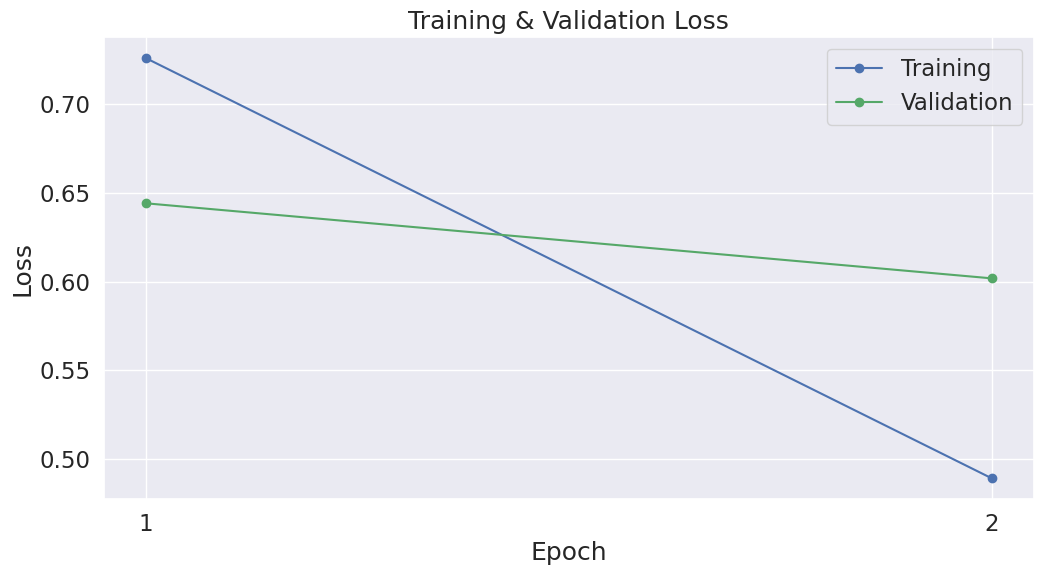

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

13. Load and test the model.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Question: 👤 How can I learn how to code in Python?

Response 1: 🤖 The Python programming language is an interpreted, high-level programming language that is widely used in various domains, including web development, scientific computing, machine learning, and more. Python is extensively used in diverse industries and is used in a wide range of applications, including web development, scientific computing, machine learning, and more.
Response 2: 🤖 Learning to code in Python is a great way to expand your skillset and find creative ways to use Python. The Python programming language is versatile and can be used to create a wide range of applications. Python is a versatile language that can be used to develop a wide range of applications, including web applications, scientific computing, artificial intelligence, machine learning, and more. You can use Python to build a website, a mobile app, or even an entire web application.


Done! 🤗